**Program**: 4_NSCH_AHR_PCA_Analysis<br>
**Class**: Fall 2025, Machine Learning, Project<br>
**Member**: Vanessa Thorsten<br>
**Description**: This program reads in the analysis dataset NSCH_AHR_state.csv, which provides data summarized at the state-level. Continuous variables are kept and standardized, and PCA analysis is performed.<br>
<br>
**Outputs**: The following data visualizations are provided for the dataset:<br>
- Q2_good_immun_pairwise_scatter
- PCA_loadings.html
- Q2_good_immun_PC_variance.png
- Q2_PCA_cumulative_variance.png
- Q2_good_immun_2PC.png
- Q2_good_immun_3PC.png

**Program History/Modifications**:<br>
09/20/2025    Initial Version

In [1]:
#Read in packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
#Combined state level data
df_state = pd.read_csv("NSCH_AHR_state.csv")
df_state.head()

,Unnamed: 0,STATE,nomChHlthSt_23_1.0_proportion,nomChHlthSt_23_2.0_proportion,PrevMed_23_1.0_proportion,PrevMed_23_2.0_proportion,K4Q01_1.0_proportion,K4Q01_2.0_proportion,smAdeqIns_23_1.0_proportion,smAdeqIns_23_2.0_proportion,...,immunizations,complete_hs,population_LT18,Poverty,primary_care_providers,public_health,support_engagement_annual,Uninsured,good_immun_cat,Region
0,0,AK,0.9245,0.0755,0.7562,0.2438,0.8580,0.1420,0.6341,0.3659,...,59.8,93.2,23.9,10.4,359.3,334.0,0.024,10.4,Low,West
1,1,AL,0.9022,0.0978,0.7939,0.2061,0.8134,0.1866,0.7404,0.2596,...,62.6,89.1,22.1,16.0,241.0,137.0,-0.745,8.5,Low,South
2,2,AR,0.9153,0.0847,0.7550,0.2450,0.7856,0.2144,0.6842,0.3158,...,62.0,89.3,23.0,16.3,241.4,128.0,-1.020,8.9,Low,South
3,3,AZ,0.8792,0.1208,0.7597,0.2403,0.7400,0.2600,0.6240,0.3760,...,62.9,89.4,21.3,12.6,258.2,84.0,0.125,9.9,Low,West
4,4,CA,0.8839,0.1161,0.7497,0.2503,0.7087,0.2913,0.7053,0.2947,...,59.8,84.8,21.7,12.0,229.7,173.0,0.199,6.4,Low,West


In [3]:
df_state['immunizations'].describe()

count    51.000000
mean     67.900000
std       5.146688
min      57.800000
25%      64.300000
50%      67.700000
75%      70.400000
max      83.100000
Name: immunizations, dtype: float64

In [4]:
#Add variables for good preventative care coverage at 80% or more
pcare_bins = [0, 64.3, 70.4, 99.99]
pcare_labels = [0,1,2]
df_state['immune_categories'] = pd.cut(df_state['immunizations'], 
                                        bins=pcare_bins, labels=pcare_labels, 
                                        right=False).astype(int)

df_state['immune_categories'].value_counts()

immune_categories
1    26
2    13
0    12
Name: count, dtype: int64

In [5]:
#Reverse coding for poverty and uninsured to positive
df_state['Above_Poverty'] = 100 - df_state['Poverty']
df_state['Insured'] = 100 - df_state['Uninsured']

In [6]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     51 non-null     int64  
 1   STATE                          51 non-null     object 
 2   nomChHlthSt_23_1.0_proportion  51 non-null     float64
 3   nomChHlthSt_23_2.0_proportion  51 non-null     float64
 4   PrevMed_23_1.0_proportion      51 non-null     float64
 5   PrevMed_23_2.0_proportion      51 non-null     float64
 6   K4Q01_1.0_proportion           51 non-null     float64
 7   K4Q01_2.0_proportion           51 non-null     float64
 8   smAdeqIns_23_1.0_proportion    51 non-null     float64
 9   smAdeqIns_23_2.0_proportion    51 non-null     float64
 10  healthy                        51 non-null     float64
 11  preventative_care              51 non-null     float64
 12  place_for_care                 51 non-null     float

### Standardization

In [7]:
df_state[['preventative_care', 'healthy', 'place_for_care', 
          'insurance','preventative_care',
          'complete_hs','population_LT18', 'Poverty','Above_Poverty',
          'primary_care_providers','public_health',
          'Uninsured', 'Insured']].describe().round(2)

,preventative_care,healthy,place_for_care,insurance,preventative_care,complete_hs,population_LT18,Poverty,Above_Poverty,primary_care_providers,public_health,Uninsured,Insured
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00
mean,80.27,90.79,79.92,66.73,80.27,91.21,21.64,12.59,87.41,301.36,154.20,7.18,92.82
std,4.20,2.06,4.44,4.16,4.20,2.36,1.92,2.51,2.51,55.17,145.51,2.68,2.68
min,69.80,86.20,69.70,59.00,69.80,84.80,17.70,8.30,80.50,221.00,66.00,2.60,83.60
25%,77.50,89.40,76.70,63.40,77.50,89.55,20.50,11.05,86.35,265.15,96.00,5.40,91.00
50%,80.20,91.00,79.90,65.80,80.20,91.40,21.60,12.20,87.80,298.60,123.00,6.50,93.50
75%,82.35,92.40,82.60,69.10,82.35,93.05,23.00,13.65,88.95,327.95,156.50,9.00,94.60
max,89.30,95.40,88.60,78.30,89.30,95.50,27.30,19.50,91.70,553.60,1084.00,16.40,97.40


In [8]:
#'support_engagement_annual' is already scaled
cols_for_scaling = ['preventative_care', 'healthy', 'place_for_care', 
          'complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health','Insured']

df_filtered = df_state[cols_for_scaling]

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_filtered), 
                            columns=df_filtered.columns, index=df_filtered.index)

#Add 'STATE', support engagement and preventative care category back to the standardized DataFrame
df_state_std = pd.concat(
    [df_scaled, df_state[['STATE', 'support_engagement_annual', 'immune_categories', 'good_immun_cat']]], 
    axis=1
)

print(df_state_std.head())
print(df_state_std.columns)

   preventative_care   healthy  place_for_care  complete_hs  population_LT18  \
0          -1.122213  0.788225        1.335243     0.851669         1.188172   
1          -0.208795 -0.291615        0.312760    -0.906317         0.242169   
2          -1.146250  0.346473       -0.300730    -0.820562         0.715171   
3          -1.026063 -1.420538       -1.345935    -0.777684        -0.178277   
4          -1.266437 -1.175120       -2.050312    -2.750058         0.031946   

   Above_Poverty  primary_care_providers  public_health   Insured STATE  \
0       0.882954                1.060668       1.247995 -1.211135    AK   
1      -1.374626               -1.104925      -0.119356 -0.495532    AL   
2      -1.495568               -1.097603      -0.181824 -0.646185    AR   
3      -0.003952               -0.790063      -0.487222 -1.022819    AZ   
4       0.237931               -1.311782       0.130516  0.295399    CA   

   support_engagement_annual  immune_categories good_immun_cat  
0  

In [9]:
describe_std = df_state_std[['preventative_care', 'healthy', 'place_for_care', 
          'complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health','Insured',
          'support_engagement_annual']].describe().round(2)

#add row for the number missing to the output
describe_std.loc['missing'] = df_state_std[['preventative_care', 'healthy', 'place_for_care', 
          'complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health','Insured',
          'support_engagement_annual']].isna().sum()

#Print summary statistics
describe_std

,preventative_care,healthy,place_for_care,complete_hs,population_LT18,Above_Poverty,primary_care_providers,public_health,Insured,support_engagement_annual
count,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,51.00,50.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.14
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,1.01,0.48
min,-2.52,-2.25,-2.32,-2.75,-2.07,-2.79,-1.47,-0.61,-3.47,-1.02
25%,-0.67,-0.68,-0.73,-0.71,-0.60,-0.43,-0.66,-0.40,-0.68,-0.56
50%,-0.02,0.10,-0.01,0.08,-0.02,0.16,-0.05,-0.22,0.26,-0.02
75%,0.50,0.79,0.61,0.79,0.72,0.62,0.49,0.02,0.67,0.24
max,2.17,2.26,1.97,1.84,2.98,1.73,4.62,6.45,1.73,0.75
missing,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [10]:
print (df_state_std[df_state_std['support_engagement_annual'].isna()])

   preventative_care   healthy  place_for_care  complete_hs  population_LT18  \
7           2.098788 -0.046196       -0.527949      0.63728        -1.597283   

   Above_Poverty  primary_care_providers  public_health   Insured STATE  \
7      -0.326464                4.617513       6.453647  1.688943    DC   

   support_engagement_annual  immune_categories  good_immun_cat  
7                        NaN                  2  Medium or high  


In [11]:
#Drop the row for Washington DC and limit the analysis to the 50 states
df_state_std = df_state_std[df_state_std['STATE'] != "DC"]
df_state_std = df_state_std.reset_index(drop=True)
df_state_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   preventative_care          50 non-null     float64
 1   healthy                    50 non-null     float64
 2   place_for_care             50 non-null     float64
 3   complete_hs                50 non-null     float64
 4   population_LT18            50 non-null     float64
 5   Above_Poverty              50 non-null     float64
 6   primary_care_providers     50 non-null     float64
 7   public_health              50 non-null     float64
 8   Insured                    50 non-null     float64
 9   STATE                      50 non-null     object 
 10  support_engagement_annual  50 non-null     float64
 11  immune_categories          50 non-null     int32  
 12  good_immun_cat             50 non-null     object 
dtypes: float64(10), int32(1), object(2)
memory usage: 5.

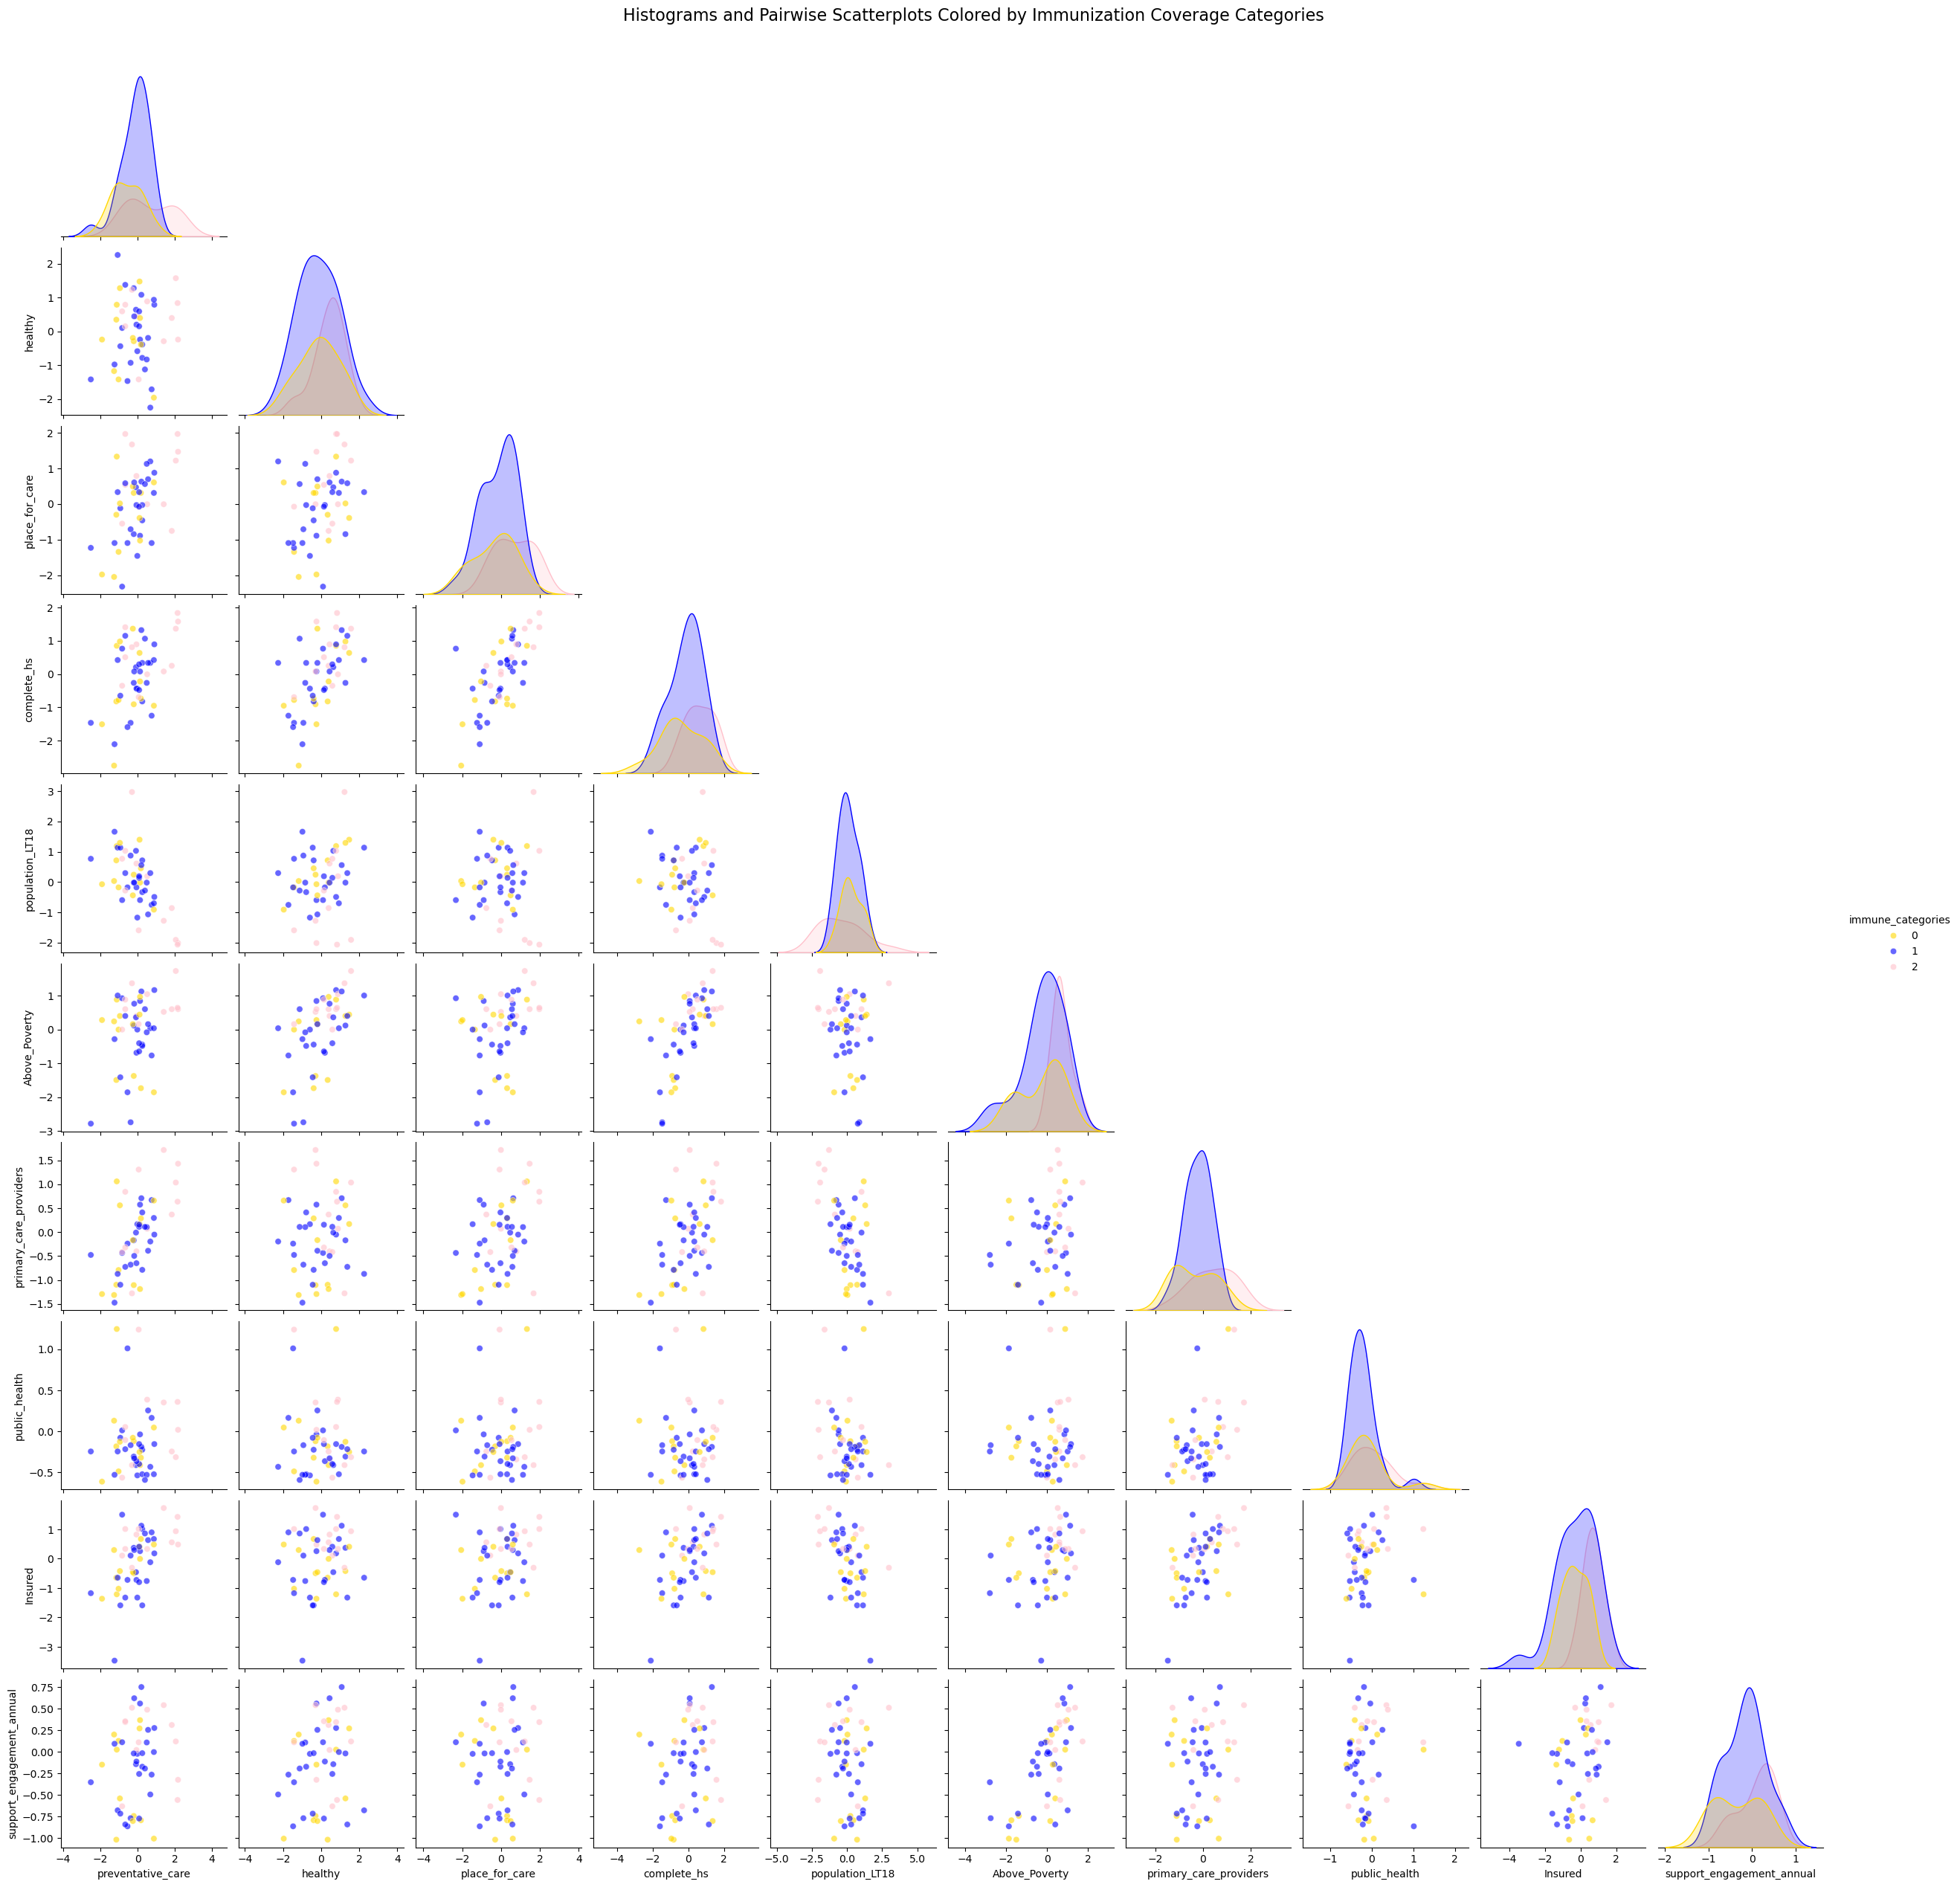

In [12]:
#Panel histograms and scatterplots with pairwise comparisons

#Create pairplot with hue
sns.pairplot(df_state_std, 
             hue='immune_categories', 
             kind='scatter', 
             corner=True, 
             plot_kws={'alpha': 0.6},
             palette=['gold', 'blue', 'pink'])

#title
plt.suptitle('Histograms and Pairwise Scatterplots Colored by Immunization Coverage Categories', fontsize=16, y=1.02)

# Show plot
plt.show()

In [13]:
#The three categories does not appear to bring forward any patterns. Try the two category variable.
#Drop the three-level variable from the dataset.
df_state_std.drop(columns=['immune_categories'], inplace=True)

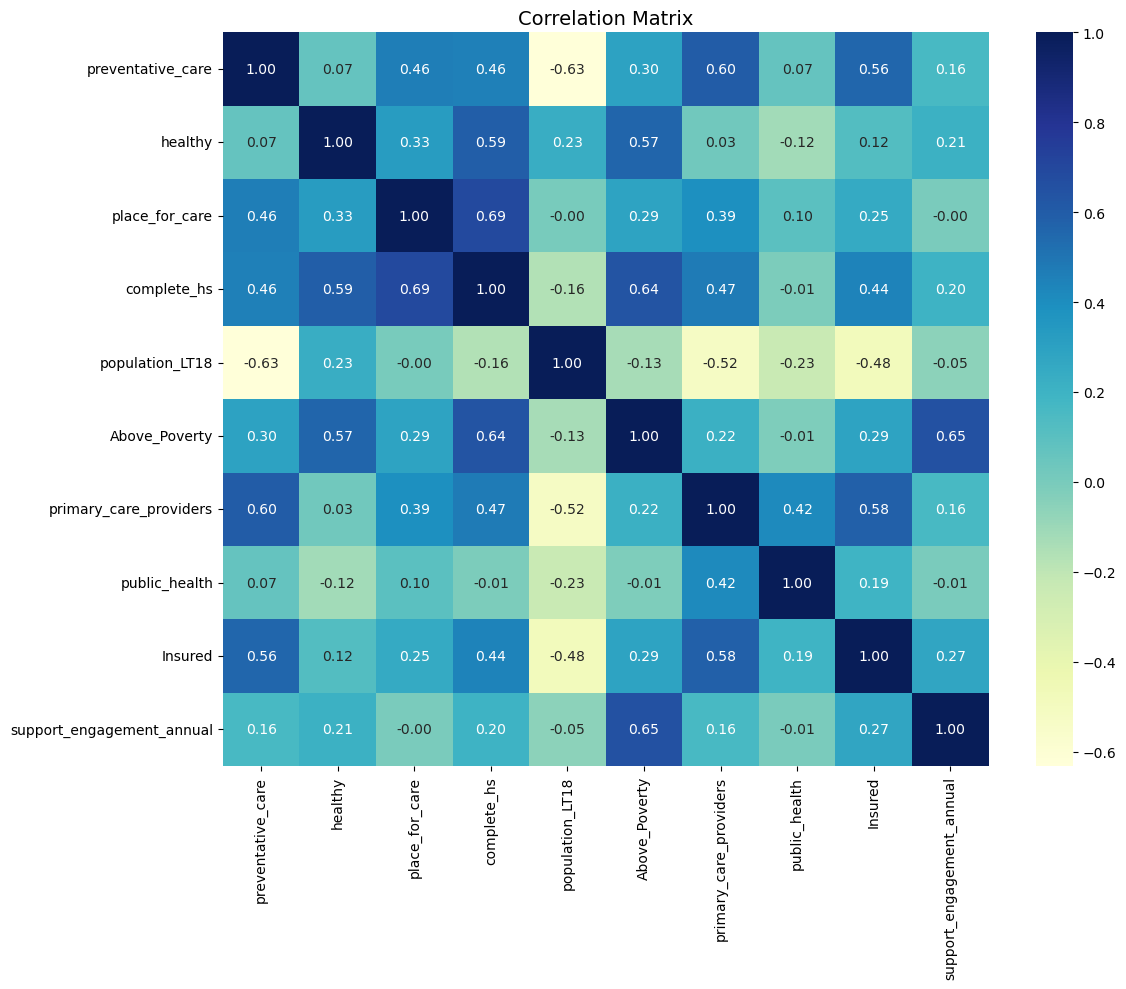

In [14]:
plt.figure(figsize=(12, 10))

#Pull off the numeric variables
numeric_df = df_state_std.select_dtypes(include='number')

#Calculate the correlation matrix
corr_matrix = numeric_df.corr()

#Plot
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='YlGnBu')

plt.title('Correlation Matrix', fontsize=14)
plt.tight_layout()

# Save the plot
plt.savefig('Q2_PCA_heat.png', dpi=300)  

plt.show()

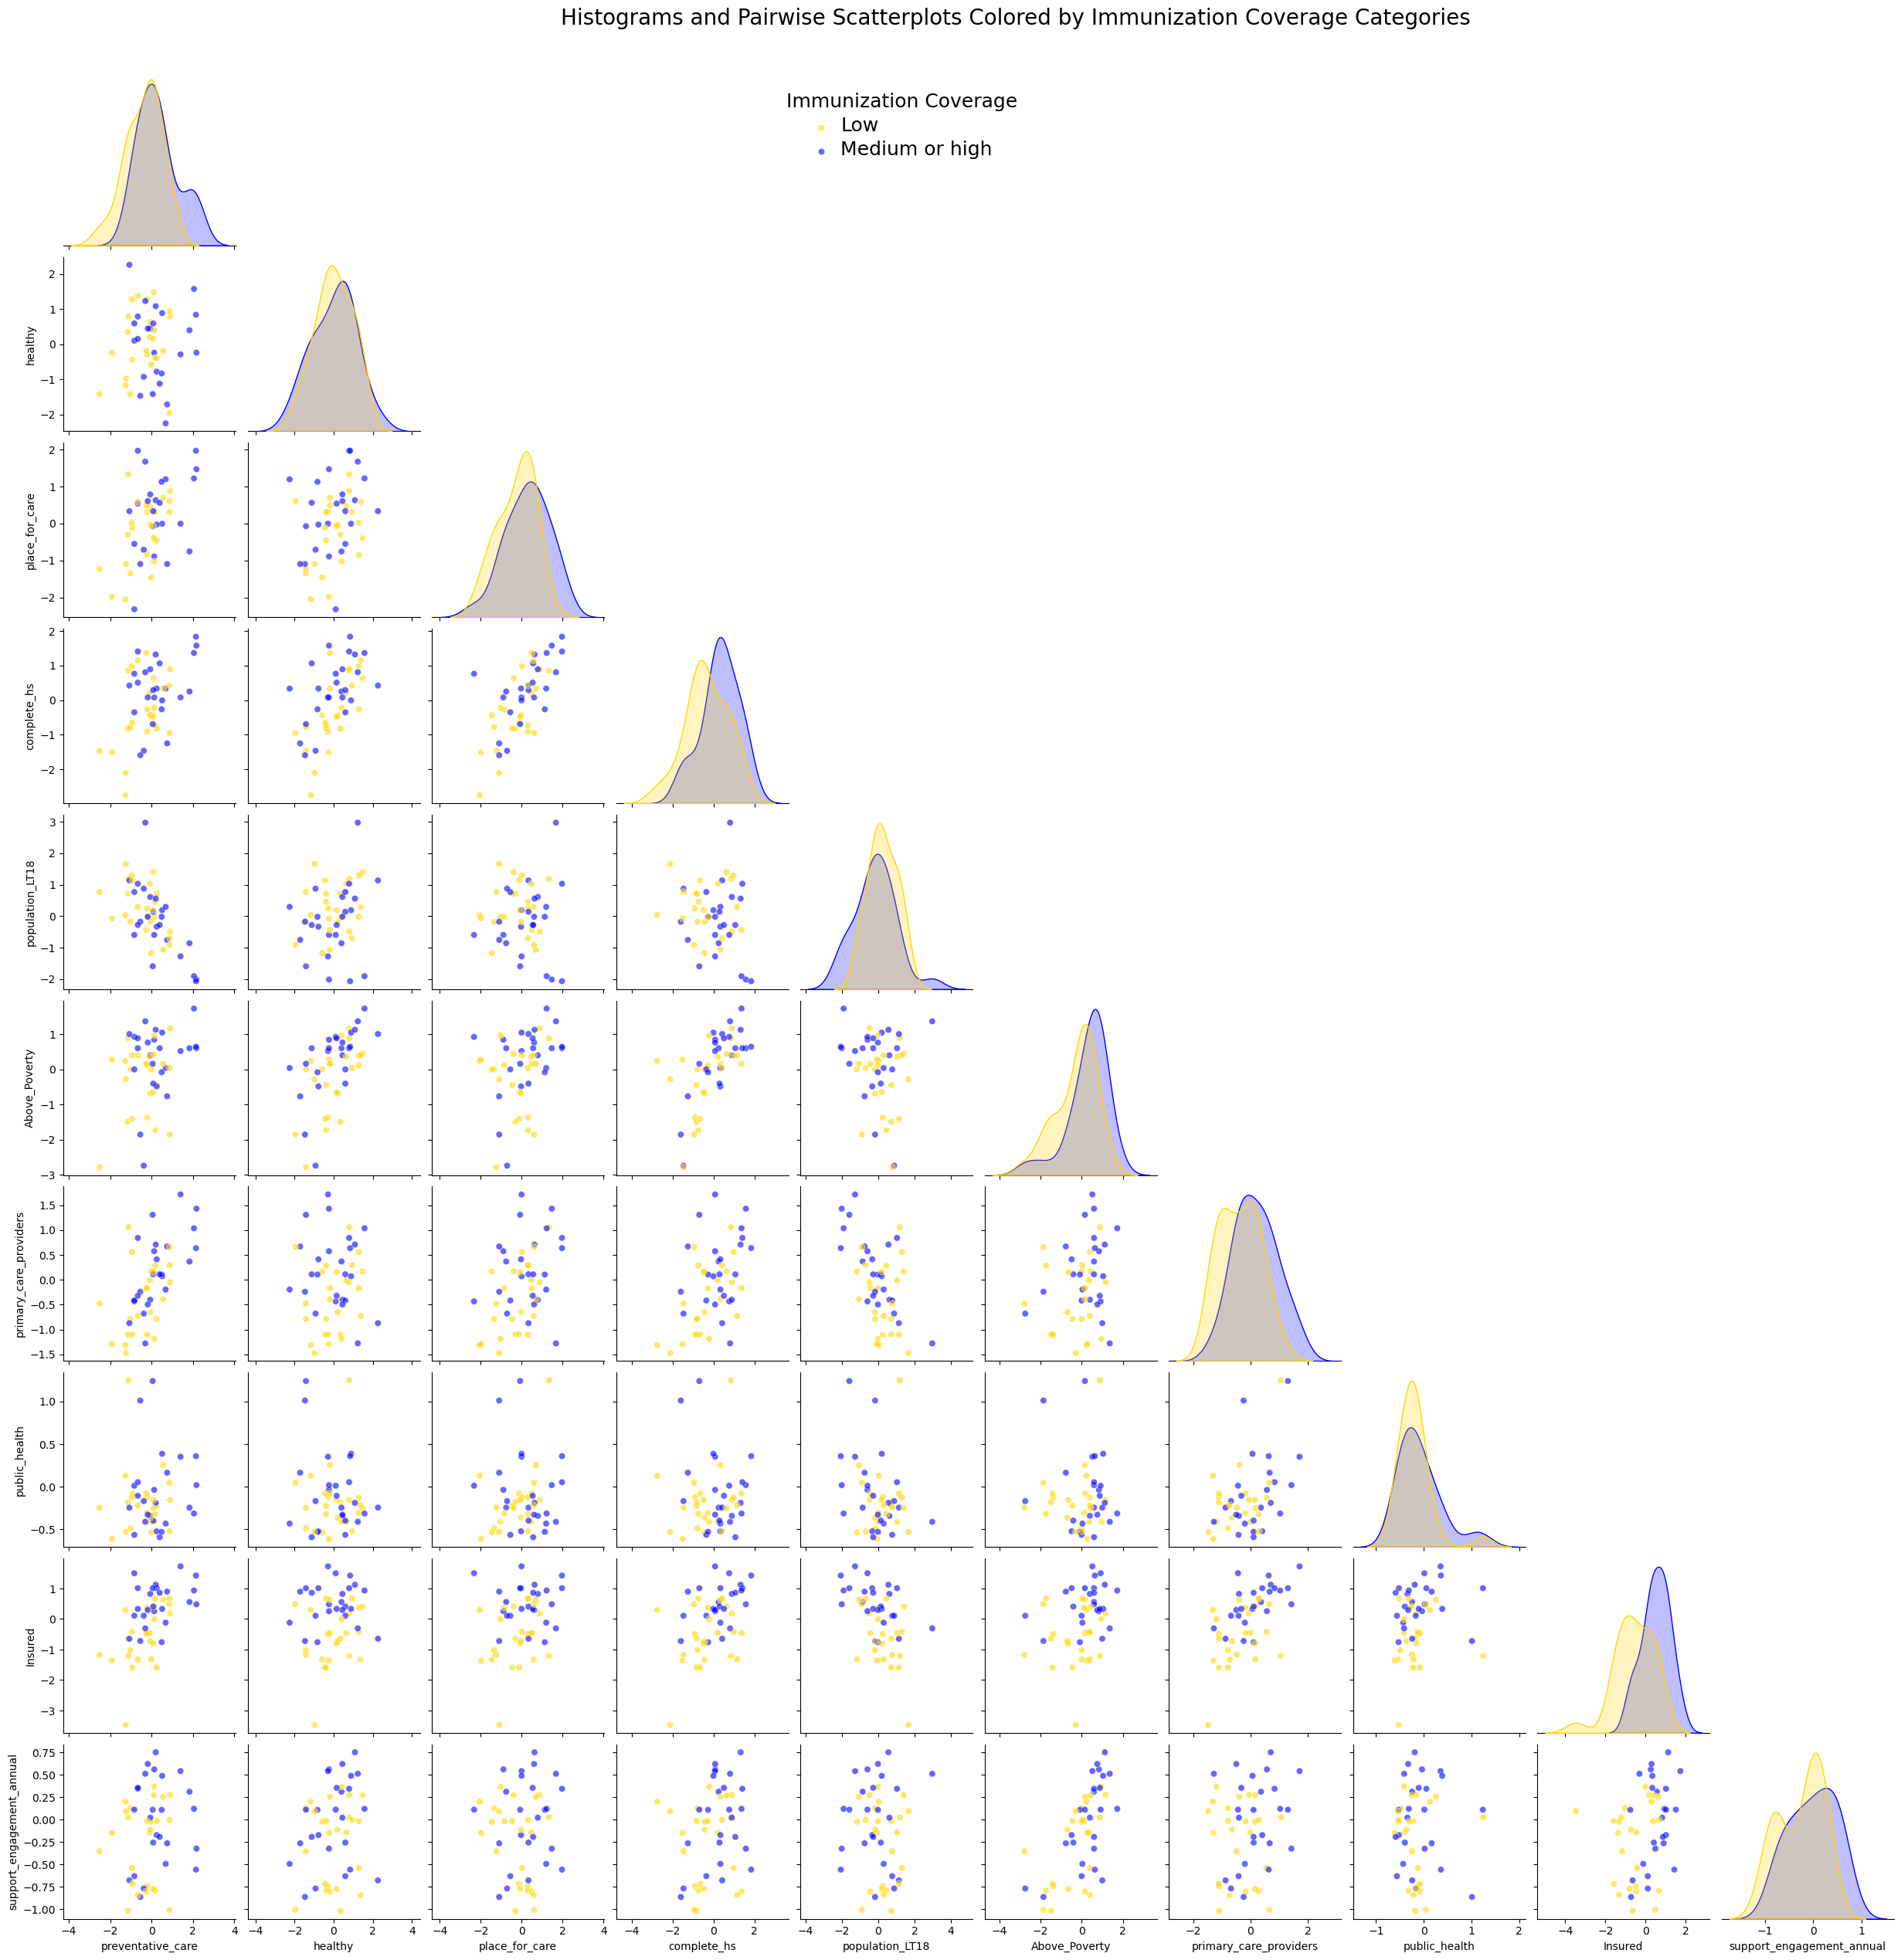

In [15]:
#Create pairplot with hue
pairplot = sns.pairplot(df_state_std, 
             hue='good_immun_cat', 
             kind='scatter', 
             corner=True, 
             plot_kws={'alpha': 0.6},
             palette=['gold', 'blue'])

#title
pairplot.fig.suptitle('Histograms and Pairwise Scatterplots Colored by Immunization Coverage Categories', fontsize=20, y=1.02)

#Make legend easier to see
pairplot._legend.set_title("Immunization Coverage")
pairplot._legend.get_title().set_fontsize(18)
pairplot._legend.set_bbox_to_anchor((0.5, 0.95)),
for text in pairplot._legend.texts:
    text.set_fontsize(18)

# Save the plot
plt.savefig('Q2_good_immun_pairwise_scatter.png', dpi=300)  
# Show plot
plt.show()

### PCA Analysis

In [16]:
#Limit to select features
features_std = df_state_std[['preventative_care', 'healthy', 'place_for_care', 
          'complete_hs','population_LT18', 'Above_Poverty',
          'primary_care_providers','public_health','Insured',
          'support_engagement_annual']]

#initialize the PCA
pca = PCA()

#Fit the principle components
principalComponents = pca.fit_transform(features_std)

#Create a dataframe of the principle components
principalDf = pd.DataFrame(data = principalComponents)

#Rename the columns to PC 1 - PC 8
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10'])

#Add the target variable of preventative care coverage to the dataset
df_state_pc = pd.concat([principalDf, df_state_std['good_immun_cat']], axis = 1)
df_state_pc['good_immun_cat'].value_counts()

good_immun_cat
Low               25
Medium or high    25
Name: count, dtype: int64

In [17]:
#Get the component loadings (eigenvectors)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so each row is a feature
    columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10'],
    index=features_std.columns
)

#Round for readability
loadings = loadings.round(3)

#Display the loadings table
loadings

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10
preventative_care,-0.389,-0.322,-0.107,0.296,-0.280,-0.535,-0.350,-0.229,-0.312,-0.096
healthy,-0.272,0.535,0.184,-0.214,-0.648,0.077,-0.276,0.191,0.146,-0.024
place_for_care,-0.368,0.162,-0.698,0.143,0.203,-0.102,0.033,0.444,0.265,0.103
complete_hs,-0.475,0.228,-0.129,-0.004,0.009,0.277,0.497,-0.455,-0.195,-0.371
population_LT18,0.237,0.550,-0.248,-0.318,0.322,-0.302,-0.307,-0.331,-0.279,0.048
Above_Poverty,-0.374,0.291,0.524,0.357,0.401,-0.038,0.000,0.115,-0.179,0.407
primary_care_providers,-0.278,-0.238,-0.102,-0.145,0.160,0.526,-0.528,-0.365,0.224,0.265
public_health,-0.029,-0.082,-0.029,-0.079,0.146,0.367,-0.289,0.478,-0.613,-0.375
Insured,-0.363,-0.281,0.165,-0.767,0.142,-0.289,0.187,0.154,-0.028,0.107
support_engagement_annual,-0.090,0.049,0.275,0.048,0.359,-0.183,-0.249,0.004,0.486,-0.671


In [18]:
#Save table
#Convert index into a column
loadings_reset = loadings.reset_index()

#Rename the column 'Feature' instead of 'index'
loadings_reset.rename(columns={'index': 'Feature'}, inplace=True)

# Save to HTML
loadings_reset.to_html("PCA_loadings.html", index=False)

In [19]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.431752  , 0.2313787 , 0.11276014, 0.06387251, 0.0490591 ,
       0.03975139, 0.03141306, 0.02136119, 0.01109321, 0.00755869])

In [20]:
pca.explained_variance_ratio_.cumsum()

array([0.431752  , 0.6631307 , 0.77589084, 0.83976335, 0.88882245,
       0.92857384, 0.95998691, 0.9813481 , 0.99244131, 1.        ])

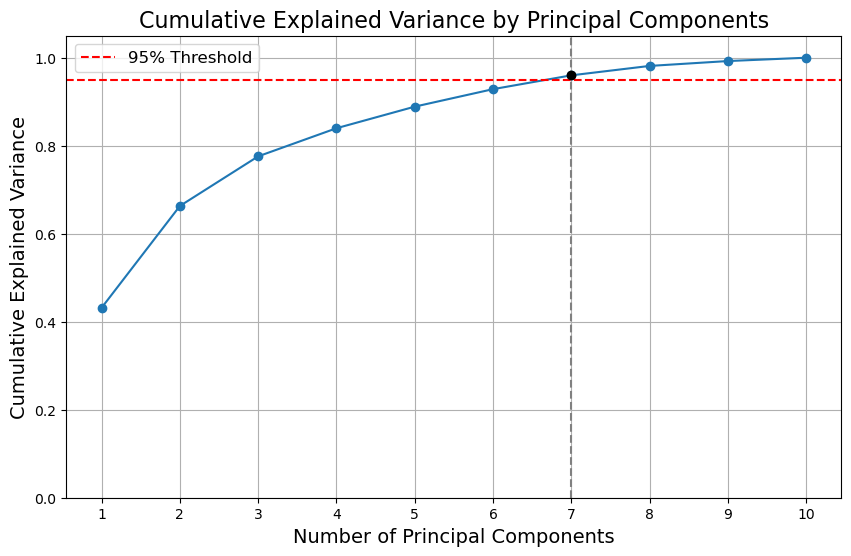

In [21]:
cumulative_variance = np.cumsum(explained_variance)

#Plot a cummulative line graph with a mark when 95% of the variance is explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')

#Add a marker for when 95% of the variance is explained
threshold_index = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=threshold_index, color='gray', linestyle='--')
plt.scatter(threshold_index, cumulative_variance[threshold_index-1], color='black', zorder=5)

#Add the labels and title
plt.title('Cumulative Explained Variance by Principal Components', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.xticks(range(1, len(cumulative_variance)+1))
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(fontsize=12)

# Save plot
plt.savefig('Q2_PCA_cumulative_variance.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


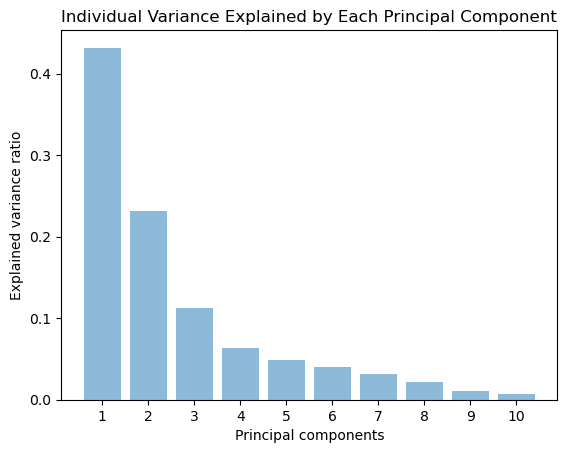

In [22]:
# Plot for individual explained variance
plt.figure()
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(1, len(explained_variance) + 1))
plt.title('Individual Variance Explained by Each Principal Component')
plt.grid(False)

plt.show()

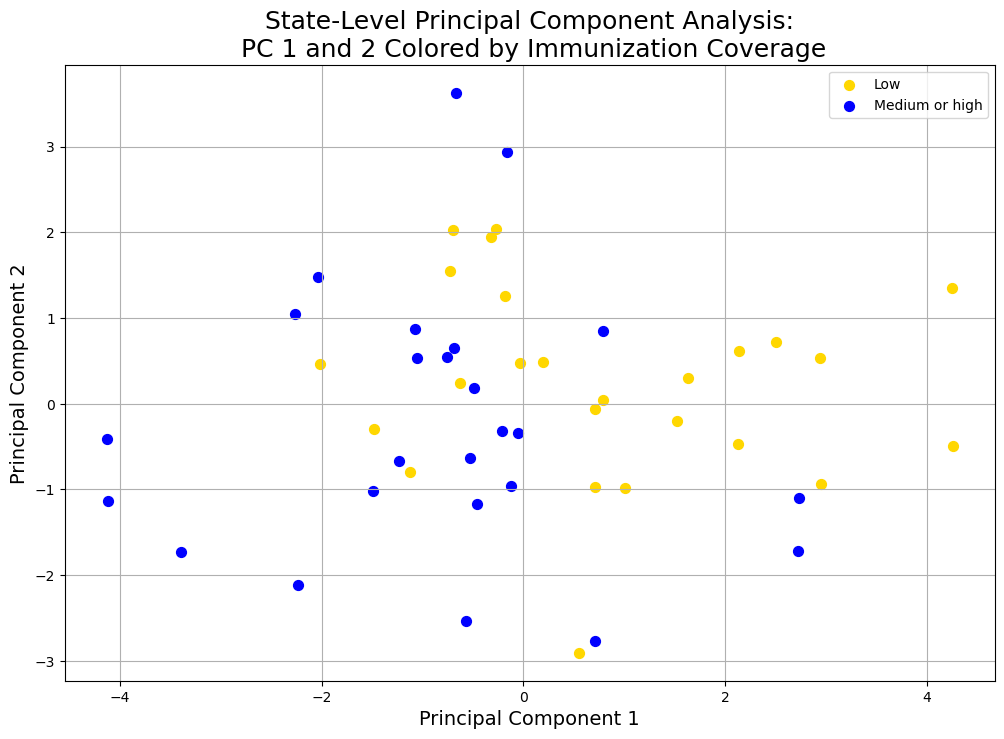

In [23]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 14)
ax.set_ylabel('Principal Component 2', fontsize = 14)
ax.set_title('State-Level Principal Component Analysis:\n PC 1 and 2 Colored by Immunization Coverage', fontsize = 18)

targetsName = ['Low', 'Medium or high']
colors = ['gold', 'blue']
for target, color in zip(targetsName,colors):
    indicesToKeep = df_state_pc['good_immun_cat'] == target
    ax.scatter(df_state_pc.loc[indicesToKeep, 'PC 1']
               , df_state_pc.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targetsName)
ax.grid()

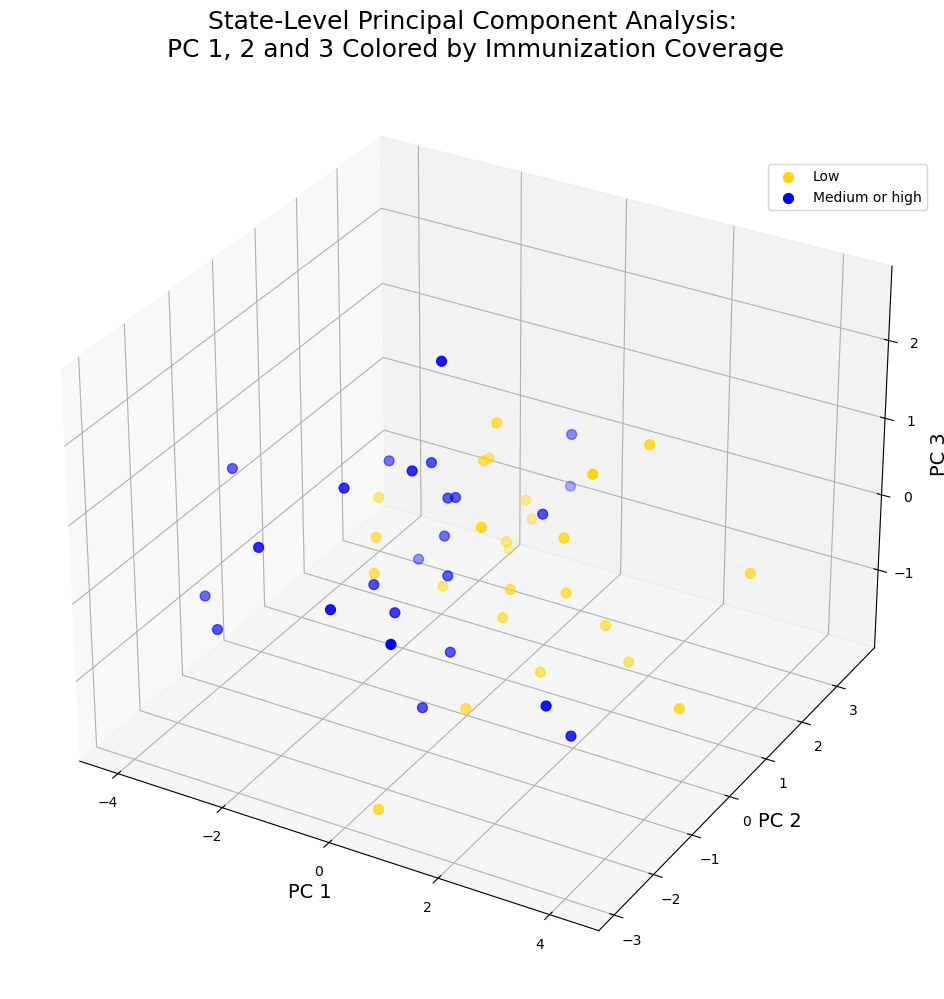

In [24]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1,  projection='3d')
ax.set_xlabel('PC 1', fontsize = 14)
ax.set_ylabel('PC 2', fontsize = 14)
ax.set_zlabel('PC 3', fontsize = 14)
#Rotate z-label so that it is not cut off
ax.zaxis.label.set_rotation(90)

ax.set_title('State-Level Principal Component Analysis:\n PC 1, 2 and 3 Colored by Immunization Coverage', fontsize = 18)

targetsName = ['Low', 'Medium or high']
colors = ['gold', 'blue']
for target, color in zip(targetsName,colors):
    indicesToKeep = df_state_pc['good_immun_cat'] == target
    ax.scatter(  df_state_pc.loc[indicesToKeep, 'PC 1']
               , df_state_pc.loc[indicesToKeep, 'PC 2']
               , df_state_pc.loc[indicesToKeep, 'PC 3']
               , c = color
               , s = 50)
ax.legend(targetsName, loc='upper right', bbox_to_anchor=(1, 0.9))
ax.grid()

# Save the plot
plt.savefig('Q2_good_immun_3PC.png', dpi=300)  


In [25]:
df_state_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PC 1            50 non-null     float64
 1   PC 2            50 non-null     float64
 2   PC 3            50 non-null     float64
 3   PC 4            50 non-null     float64
 4   PC 5            50 non-null     float64
 5   PC 6            50 non-null     float64
 6   PC 7            50 non-null     float64
 7   PC 8            50 non-null     float64
 8   PC 9            50 non-null     float64
 9   PC 10           50 non-null     float64
 10  good_immun_cat  50 non-null     object 
dtypes: float64(10), object(1)
memory usage: 4.4+ KB


In [26]:
#Add the features to the dataset
df_state_std_PCA = pd.concat([df_state_std[['STATE', 'preventative_care', 'healthy', 'place_for_care',
                                            'complete_hs','population_LT18', 'Above_Poverty',
                                            'primary_care_providers','public_health','Insured',
                                            'support_engagement_annual']],df_state_pc], axis = 1)
#Save to CSV
df_state_std_PCA.to_csv("df_state_std_PCA.csv", index=False)

In [27]:
df_state_std_PCA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STATE                      50 non-null     object 
 1   preventative_care          50 non-null     float64
 2   healthy                    50 non-null     float64
 3   place_for_care             50 non-null     float64
 4   complete_hs                50 non-null     float64
 5   population_LT18            50 non-null     float64
 6   Above_Poverty              50 non-null     float64
 7   primary_care_providers     50 non-null     float64
 8   public_health              50 non-null     float64
 9   Insured                    50 non-null     float64
 10  support_engagement_annual  50 non-null     float64
 11  PC 1                       50 non-null     float64
 12  PC 2                       50 non-null     float64
 13  PC 3                       50 non-null     float64
 